In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt

## Import jeu de train, test, validation

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
mnist = tf.keras.datasets.mnist


# Définir les chemins des répertoires contenant vos images d'entraînement, de test et de validation
train_dir = 'C:\\Users\\Utilisateur\\Documents\\12_non supervise\\Alien_Predator\\Train'
test_dir = 'C:\\Users\\Utilisateur\\Documents\\12_non supervise\\Alien_Predator\\Test'
validation_dir = 'C:\\Users\\Utilisateur\\Documents\\12_non supervise\\Alien_Predator\\Validation'


# Définir la taille des images d'entrée et d'autres paramètres de prétraitement
img_size = (150, 150)
batch_size = 494

# Créer des générateurs d'images pour l'entraînement, le test et la validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Mise à l'échelle des pixels de 0 à 255 à 0 à 1
    # rotation_range=20,  # Rotation aléatoire des images
    # width_shift_range=0.2,  # Translation horizontale aléatoire
    # height_shift_range=0.2,  # Translation verticale aléatoire
    # shear_range=0.2,  # Déformation affine aléatoire
    # zoom_range=0.2,  # Zoom aléatoire
    # horizontal_flip=True,  # Retournement horizontal aléatoire
    # fill_mode='nearest'  # Mode de remplissage en cas de transformation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=494,
    class_mode='binary'  # Changez ceci en fonction de votre problème (binaire, catégoriel, etc.)
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=200,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=200,
    class_mode='binary'
)

Found 494 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [3]:
class_names = list(train_generator.class_indices.keys())
class_names

['Alien', 'Predator']

In [4]:
# Extraction des données d'entraînement
X_train, y_train = next(train_generator)

# Extraction des données de test
X_test, y_test = next(test_generator)

# Extraction des données de validation
X_val, y_val = next(validation_generator)
X_train.shape, y_train.shape

((494, 150, 150, 3), (494,))

## split en images( x) et labels (y) le jeu de train et test

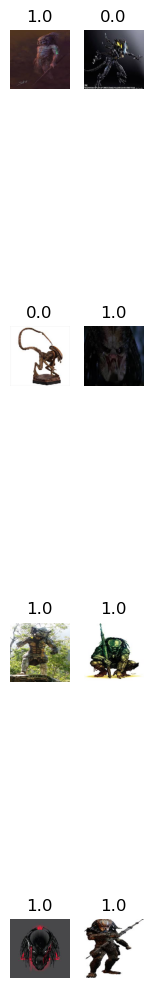

(494,)

In [5]:
import matplotlib.pyplot as plt

# Charger plusieurs batches d'images du générateur d'entraînement
num_batches = 4  # Le nombre de batches à charger
images_per_batch = 16  # Le nombre d'images par batch
total_images = num_batches * images_per_batch

# Créer une figure avec une grille pour afficher les images
plt.figure(figsize=(12, 12))
for batch in range(num_batches):
    images, labels = next(train_generator)
    for i in range(2):
        plt.subplot(num_batches, images_per_batch, batch * images_per_batch + i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')

plt.tight_layout()
plt.show()

labels.shape

In [6]:
# next(train_generator)[0][:10].shape


In [7]:
# Y_train=np.argmax(labels, axis =1)
# Y_train.shape

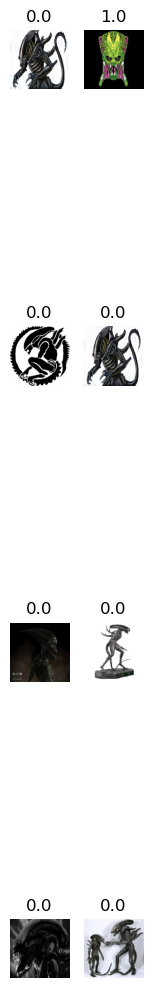

In [8]:

plt.figure(figsize=(12, 12))
for batch in range(num_batches):
    images_test, labels_test = next(test_generator)
    for i in range(2):
        plt.subplot(num_batches, images_per_batch, batch * images_per_batch + i + 1)
        plt.imshow(images_test[i])
        plt.title(labels_test[i])
        plt.axis('off')

plt.tight_layout()
plt.show()

# Y_test=np.argmax(labels_test, axis =1)
# Y_test
# labels_test

In [9]:
print(np.min(images), np.max(images))

0.0 1.0


### Create the model : The Keras [Sequential]

In [12]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Créez un modèle CNN simple
model = models.Sequential([
    layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
# Ajoutez les couches de classification
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])



### Compile the model

In [13]:
# Compilez le modèle
model.compile(optimizer='adam',
              loss=tf.losses.binary_crossentropy,
              metrics=['accuracy'])



In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

### Train the model

In [14]:

# Entraînez le modèle
history = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    batch_size = 494
    # validation_steps=validation_generator.samples // batch_size
)


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.6919 - accuracy: 0.5020 - val_loss: 5.8146 - val_accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 4s 4s/step - loss: 6.0492 - accuracy: 0.5000 - val_loss: 0.6821 - val_accuracy: 0.5800
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 0.6606 - accuracy: 0.6113 - val_loss: 1.4996 - val_accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 4s 4s/step - loss: 1.4386 - accuracy: 0.5000 - val_loss: 1.2383 - val_accuracy: 0.5000
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 1.1931 - accuracy: 0.5000 - val_loss: 0.9579 - val_accuracy: 0.5000
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 0.9275 - accuracy: 0.5000 - val_loss: 0.7977 - val_accuracy: 0.5000
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 0.7781 - accuracy: 0.5000 - val_loss: 0.7287 - val_accuracy: 0.5000
Epoch 8/100
1/1 [=================

In [44]:
# Sauvegardez le modèle pour une utilisation future
model.save('mon_modele_cnn.h5')

C:\Users\Utilisateur\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Visualize training results

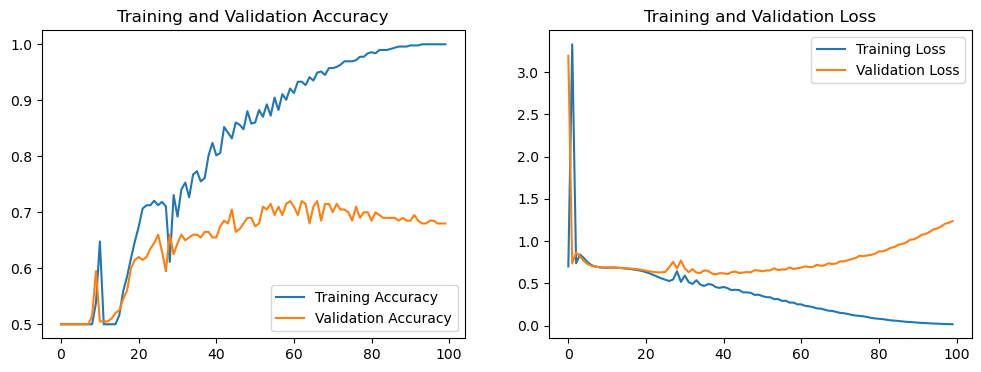

In [17]:
epochs=100

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Évaluez le modèle sur l'ensemble de test

In [20]:
# Évaluez le modèle sur l'ensemble d'entraînement
train_loss, train_accuracy = model.evaluate(train_generator, steps=len(train_generator))
print("Training accuracy:", train_accuracy)

# Évaluez le modèle sur l'ensemble de validation
validation_loss, validation_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print("Validation accuracy:", validation_accuracy)

# Évaluez le modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_accuracy)


1/1 [==============================] - 1s 1s/step - loss: 4.9531e-04 - accuracy: 1.0000
Training accuracy: 1.0
1/1 [==============================] - 1s 558ms/step - loss: 2.0098 - accuracy: 0.6800
Validation accuracy: 0.6800000071525574
1/1 [==============================] - 1s 587ms/step - loss: 2.1633 - accuracy: 0.6950
Test accuracy: 0.6949999928474426


In [42]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_val= model.predict(X_val)

7/7 [==============================] - 0s 50ms/step


In [43]:
# Conversion des probabilités
y_pred_train_prob= [1 if prob > 0.5 else 0 for prob in np.ravel(y_pred_train)]
print(y_pred_train_prob[:10])

y_pred_test_prob= [1 if prob > 0.5 else 0 for prob in np.ravel(y_pred_test)]
print(y_pred_test_prob[:10])

y_pred_val_prob= [1 if prob > 0.5 else 0 for prob in np.ravel(y_pred_val)]
print(y_pred_val_prob[:10])

[0, 1, 0, 0, 0, 0, 1, 0, 0, 1]
[1, 1, 1, 1, 1, 0, 0, 0, 1, 0]
[1, 1, 0, 0, 1, 1, 0, 0, 0, 0]


In [51]:
# Matrice de confusion jeu d'apprentissage
print("Matrice de confusion jeu d'apprentissage ")
print(confusion_matrix(y_train, y_pred_train_prob))

# Matrice de confusion jeu de test
print("Matrice de confusion jeu de test")
print(confusion_matrix(y_test, y_pred_test_prob))

# Matrice de confusion jeu de test
print("Matrice de confusion jeu de test")
print(confusion_matrix(y_val, y_pred_val_prob))

Matrice de confusion jeu d'apprentissage 
[[247   0]
 [  0 247]]
Matrice de confusion jeu de test
[[72 28]
 [33 67]]
Matrice de confusion jeu de test
[[72 28]
 [36 64]]


In [53]:
print(classification_report(y_test, y_pred_test_prob))


              precision    recall  f1-score   support

         0.0       0.69      0.72      0.70       100
         1.0       0.71      0.67      0.69       100

    accuracy                           0.69       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.70      0.69      0.69       200

